# $\mathrm{B} - \mathrm{L}$ Genesis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root, root_scalar
from scipy.interpolate import interp1d
from scipy import linalg as la
import sys
if ".." not in sys.path: sys.path.append("..")
from common import constants, cosmology
from collections import namedtuple

## Warning: for different epoch change numbers!

## Rates for Different Processes

### Yukawa Rates

In [2]:
Y_tau = 1e-2
Y_top = 0.49
Y_bottom = 6.8e-3

kappa_tau = 1.7e-3

def calc_yukawa_rate(T, kappa, Y):
    return kappa * Y**2 * T**4

def calc_yukawa_rate_tau(T):
    return calc_yukawa_rate(T, kappa_tau, Y_tau)

kappa_quarks_uptype = np.array([8e-3, 1e-2, 1.2e-2]) # \approx downtype
T_for_kappa_quarks_uptype = np.array([1e15, 1e12, 1e9])
kappa_quark_uptype_interp = interp1d(np.log(T_for_kappa_quarks_uptype), kappa_quarks_uptype, fill_value="extrapolate")

def calc_yukawa_rate_quark(T, Y):
    #kappa = kappa_quarks_uptype[1] # kappa_quark_interp(T)
    kappa = kappa_quark_uptype_interp(np.log(T))
    return calc_yukawa_rate(T, kappa, Y)

def calc_yukawa_rate_top(T):
    return calc_yukawa_rate_quark(T, Y_top)

def calc_yukawa_rate_bottom(T):
    return calc_yukawa_rate_quark(T, Y_bottom)

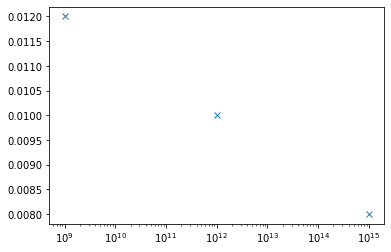

In [3]:
plt.semilogx(T_for_kappa_quarks_uptype, kappa_quarks_uptype, "x")

### Sphaleron Rates

In [4]:
g2 = 0.55
g3 = 0.6

def g_to_alpha(g): return g**2 / (4*np.pi)

alpha_2 = g_to_alpha(g2)
alpha_3 = g_to_alpha(g3)

kappa_WS = 24 # for 1e12 GeV
kappa_SS = 2.7e2 # for 1e13 GeV

def calc_weak_sphaleron_rate(T):
    return kappa_WS / 2 * alpha_2**5 * T**4

def calc_strong_sphaleron_rate(T):
    return kappa_SS / 2 * alpha_3**5 * T**4

### Weinberg Rate 

In [5]:
kappa_W = 3e-3
nu_EW = 174 # [GeV]
m_nu = 0.05e-9 # [GeV]

def calc_weinberg_op_rate(T):
    return kappa_W * m_nu**2 * T**6 / nu_EW**4

## Charge and Source Vectors

In [6]:
# Interactions:
charge_vector = np.array((
    # tau, L12, L3, q12, t,  b,  Q12, Q3,  H
    (0,    2,   1,  0,   0,  0,  6,   3,   0), # WS
    (0,    0,   0, -4,  -1, -1,  4,   2,   0), # SS
    (-1,   0,   1,  0,   0,  0,  0,   0,   1), # Y_tau
    (0,    0,   0,  0,  -1,  0,  0,   1,   1), # Y_top
    (0,    0,   0,  0,   0, -1,  0,   1,  -1), # Y_bottom
    (0,    2,   0,  0,   0,  0,  0,   0,   2), # Weinberg_12
    (0,    0,   2,  0,   0,  0,  0,   0,   2), # Weinberg_3
))

# Conserved Quantaties:
conserved = np.array((
    # tau, L12,  L3,   q12,   t,    b,  Q12,   Q3,  H
    ( -1, -1/2, -1/2,  1/6,  2/3, -1/3, 1/6,  1/6, 1/2), # Y
    (  0,  0,    0,    1/3, -2/3, -2/3, 1/3, -2/3, 0),   # B12 - 2*B3
))

N_alpha, N = charge_vector.shape
N_A = conserved.shape[0]

In [7]:
charge_names = ["tau", "L12", "L3", "q12", "t", "b", "Q12", "Q3", "H"]
process_names = ["WS", "SS", "Y_tau", "Y_top", "Y_bottom", "W_12", "W_3"]
conserved_names = ["Y", "B12 - 3*B3"]

In [8]:
[(process_name, conserved_name) 
 for conserved_name, n_A in zip(conserved_names, conserved) 
 for process_name, n_alpha in zip(process_names, charge_vector) 
 if not np.isclose(n_A @ n_alpha, 0.0)]

[('Y_tau', 'Y')]

In [9]:
g = dofs = np.array([1,4,2,12,3,3,12,6,4])

In [10]:
#                                           WS SS  Ytau Yt Yb  W12  W3 
source_vector_B_minus_L_current = np.array((0,  0,  0,  0,  0, -2, -2))
source_vector_weak_sphaleron    = np.array((1,  0,  0,  0,  0,  0,  0))
source_vector_strong_sphaleron  = np.array((0,  1,  0,  0,  0,  0,  0))
source_vector_none              = np.zeros(len(source_vector_B_minus_L_current))

## Rate Vector and Equilibration Temperatures

In [11]:
def calc_rate_vector(T):
    return np.array((
        calc_weak_sphaleron_rate(T), # WS
        calc_strong_sphaleron_rate(T), # SS
        calc_yukawa_rate_tau(T), # Y_tau
        calc_yukawa_rate_top(T), # Y_top
        calc_yukawa_rate_bottom(T), # Y_bottom
        2 * calc_weinberg_op_rate(T), # W_12
        calc_weinberg_op_rate(T), # W_3
    ))

In [12]:
def eqi_temp(alpha, plot=True, low=1e10, high=1e16):
    def ratio(T):
        gamma = calc_rate_vector(T)[alpha] / (T**3 / 6)
        expr = np.sum(charge_vector[alpha, :]**2 / g * gamma)
        H = cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T))
        return expr / H

    T_range = np.geomspace(high, low, 200)
    if plot: plt.loglog(T_range, [ratio(T) for T in T_range], label=process_names[alpha])
    
    try:
        sol = root_scalar(lambda T: ratio(T) - 1, bracket=(T_range[0], T_range[-1]), rtol=1e-10, xtol=1e-10)
        if not sol.converged: return np.nan
    except ValueError:
        return np.nan
    return sol.root

WS 2.485122e+12 GeV
SS 4.449330e+13 GeV
Y_tau 1.270354e+12 GeV
Y_top 5.761626e+15 GeV
Y_bottom 1.464511e+12 GeV
W_12 7.155469e+12 GeV
W_3 9.540625e+12 GeV


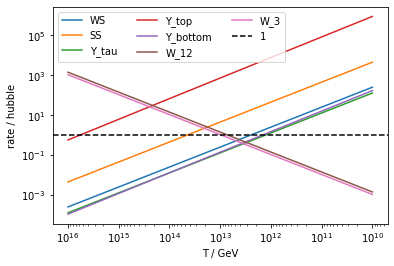

In [13]:
T_eqs = [eqi_temp(alpha) for alpha in range(charge_vector.shape[0])]
plt.axhline(1, ls="--", color="black", label="1")
plt.legend(ncol=3)
plt.gca().invert_xaxis()
plt.xlabel("T / GeV")
plt.ylabel("rate / hubble")
for name, T_eq in zip(process_names, T_eqs):
    print(name, "%e" % T_eq, "GeV")

- WS 2.485122e+12 GeV 2.5×10^12GeV good
- SS 4.449330e+13 GeV 2.8×10^13GeV ok
- Y_tau 1.270354e+12 GeV 1.3×10^12GeV good
- Y_top 5.761626e+15 GeV 4.7×10^15GeV ok
- Y_bottom 1.464511e+12 GeV Tyb'1.5×10^12GeV good
- W_12 7.155469e+12 GeV
- W_3 9.540625e+12 GeV 6×10^12GeV ok

## Axion Motion

In [14]:
# axion_motion := a dot / f / T

eta0 = 1e-9
def calc_axion_motion_const(log_T):
    return eta0

T_osc = 1e13
T_dec = 1e11
def calc_axion_motion_osc(log_T):
    T = np.exp(log_T)
    x = T_osc / T
    return eta0 * x**(-1/2) * np.sin(x**2 - 1) * np.heaviside(T_osc - T, 0.0) * np.heaviside(T - T_dec, 0.0) 

Text(0.5, 0, 'T / GeV')

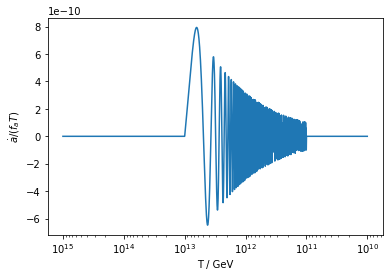

In [15]:
T_RH = 1e15
T_range = np.geomspace(T_RH, 1e10, 3000)
plt.semilogx(T_range, calc_axion_motion_osc(np.log(T_range)))
plt.gca().invert_xaxis()
plt.ylabel(r"$\dot{a} / (f_a T)$")
plt.xlabel(r"T / GeV")

## $\mathrm{B} - \mathrm{L}$ Charge

In [16]:
# tau, L12,  L3,   q12,   t,    b,  Q12,   Q3,  H
#charge_vector_B_minus_L = np.array((-1, -1, -1, 1/3, 1/3, 1/3, 1/3, 1/3, 0))
charge_vector_B_minus_L = np.array((-1, -1, -1, 1/3, 1/3, 1/3, 1/3, 1/3, 0))

def calc_B_minus_L(red_chems):
    return charge_vector_B_minus_L @ red_chems

## Transport Equation

In [17]:
def rate(log_T):
    T = np.exp(log_T)
    H = cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T))
    Gamma = calc_rate_vector(T)
    gamma = Gamma / (T**3 / 6)
    return gamma / H

In [18]:
unit = 1e-9
def transport_eq_rhs(log_T, red_chem_pot, n_S, calc_axion_motion):
    R = rate(log_T)
    axion_motion = calc_axion_motion(log_T)
    d_red_chem_pot_d_ln_T = np.array([
        1 / g[i] * sum([charge_vector[alpha, i] * R[alpha] * 
                       (np.dot(charge_vector[alpha, :], red_chem_pot)
                        - n_S[alpha] * axion_motion / unit) 
                    for alpha in range(N_alpha)])
            for i in range(N)])
    return d_red_chem_pot_d_ln_T

In [19]:
def transport_eq_jac(log_T, _ignore_red_chems, *_ignore_args):
    R = rate(log_T)
    def jac(i, j):
        return sum([1 / g[i] * charge_vector[alpha, i] * charge_vector[alpha, j] * R[alpha]
                  for alpha in range(N_alpha)])
    return np.array([[jac(i,j) for j in range(N)] for i in range(N)])

In [20]:
initial = np.zeros(charge_vector.shape[1])
start, end = np.log(T_RH), np.log(1e10)
steps = np.linspace(start, end, 500); steps[0] = start; steps[-1] = end

In [21]:
TransportEqResult = namedtuple("TransportEqResult", ["T", "red_chem_pots", "red_chem_B_minus_L"])

In [22]:
def solve_transport_eq(source_vector, calc_axion_motion=calc_axion_motion_const, solver="Radau", rtol=1e-8):
    # RK23 RK45 DOP853 Radau BDF LSODA
    sol = solve_ivp(transport_eq_rhs, (start, end), initial, jac=transport_eq_jac,
             args=(source_vector, calc_axion_motion), method=solver, rtol=rtol, t_eval=steps)
    red_chem_pots = sol.y * unit
    return TransportEqResult(T=np.exp(sol.t), red_chem_pots=red_chem_pots, 
                          red_chem_B_minus_L=calc_B_minus_L(red_chem_pots))

## Different Cases

In [23]:
def solve_and_plot(source_vector, calc_axion_motion, name, solver_kwargs={}, **kwargs):
    res = solve_transport_eq(source_vector, calc_axion_motion, **solver_kwargs)
    plot(res, name, **kwargs)
    return res

def plot(res, name, min_y=1e-12, max_y=1e-9, use_limits=True, yscale="log", xscale="log", show_eq_temps=False):
    T, red_chem_pots, red_chem_B_minus_L = res
    plt.figure(figsize=(15,5))
    plt.suptitle(name, fontsize=20)
    plt.subplot(1,2,1)
    colors = []
    for name, red_chem_pot in zip(charge_names, red_chem_pots):
        l, = plt.plot(T, np.abs(red_chem_pot) if yscale == "log" else red_chem_pot, label=name)
        colors.append(l.get_color())
    ncol = 2
    if show_eq_temps:
        ncol = 3
        for color, process_name, T_eq in zip(colors, process_names, T_eqs): # colors are not related
            plt.axvline(T_eq, color=color, ls="--", label=process_name)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.ylabel(r"$|\mu / T|$" if yscale == "log" else r"$\mu / T$", fontsize=15)
    plt.xlabel(r"T / GeV", fontsize=15)
    plt.gca().invert_xaxis()
    plt.legend(ncol=ncol)
    
    plt.subplot(1,2,2)
    plt.plot(T, np.abs(red_chem_B_minus_L) if yscale == "log" else red_chem_B_minus_L)
    #plt.axhline(1e-9)
    plt.ylabel(r"$|\mu_{\mathrm{B} - \mathrm{L}} / T|$" if yscale == "log" else r"$\mu_{\mathrm{B} - \mathrm{L}} / T$", fontsize=15)
    plt.xlabel(r"T / GeV", fontsize=15)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.gca().invert_xaxis()
    if use_limits: plt.ylim(min_y, max_y)
    plt.xlim(1e15, 1e10)
    plt.tight_layout()
    plt.show()

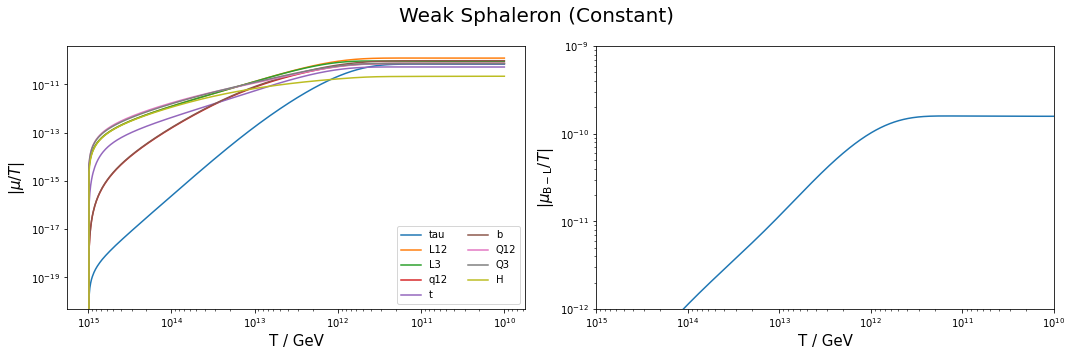

In [24]:
solve_and_plot(source_vector_weak_sphaleron, calc_axion_motion_const, "Weak Sphaleron (Constant)");

In [25]:
res_WS_osc = solve_transport_eq(source_vector_weak_sphaleron, calc_axion_motion_osc)

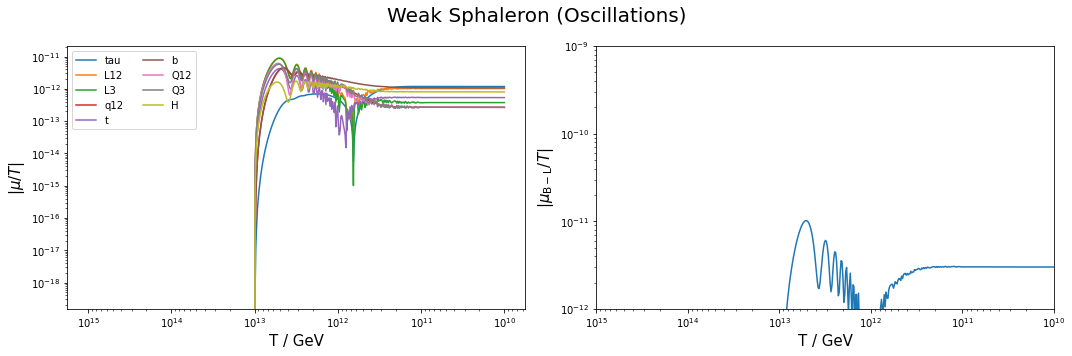

In [26]:
plot(res_WS_osc, "Weak Sphaleron (Oscillations)") # , yscale="linear", use_limits=False);

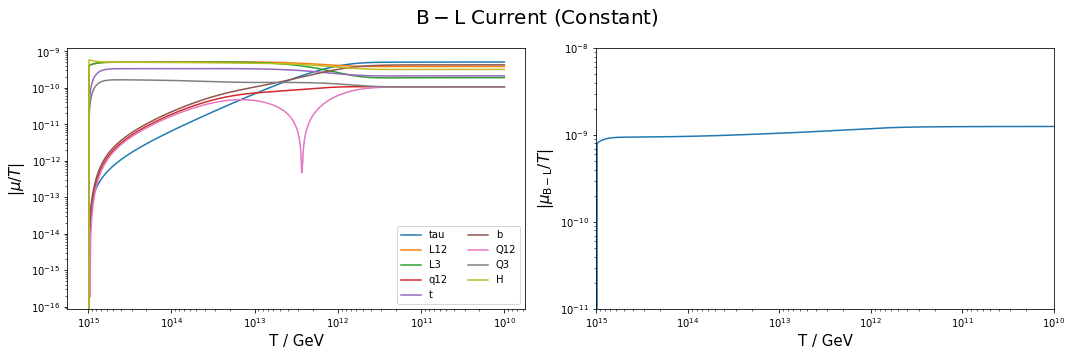

In [27]:
solve_and_plot(source_vector_B_minus_L_current, calc_axion_motion_const, r"$\mathrm{B} - \mathrm{L}$ Current (Constant)", 
               min_y=1e-11, max_y=1e-8);

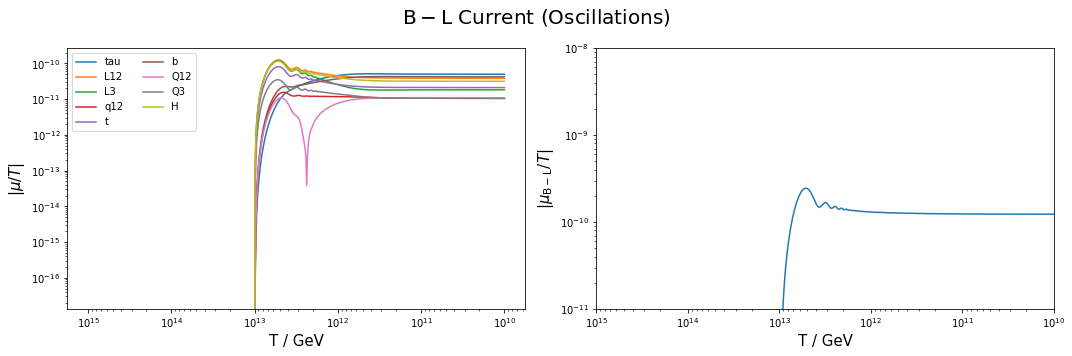

In [28]:
solve_and_plot(source_vector_B_minus_L_current, calc_axion_motion_osc, r"$\mathrm{B} - \mathrm{L}$ Current (Oscillations)", 
               min_y=1e-11, max_y=1e-8);

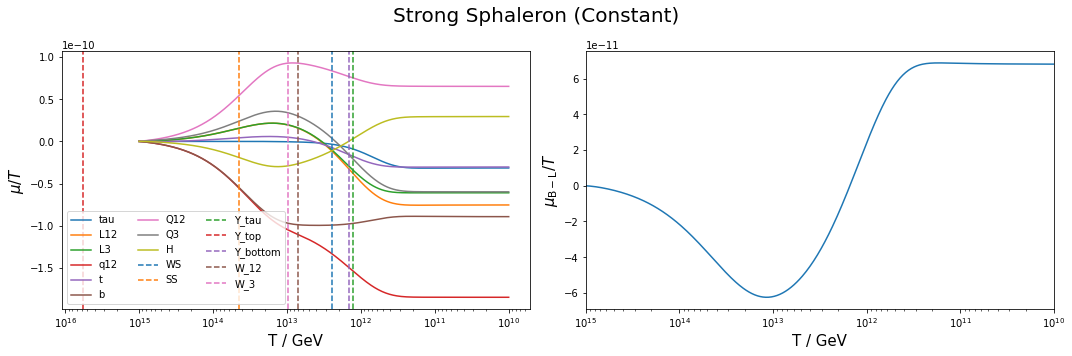

In [29]:
res_SS_const = solve_and_plot(source_vector_strong_sphaleron, calc_axion_motion_const, "Strong Sphaleron (Constant)", 
               solver_kwargs=dict(solver="BDF", rtol=1e-10), yscale="linear", use_limits=False, show_eq_temps=True)

Text(0.5, 1.0, 'These curve are supposed to be constant')

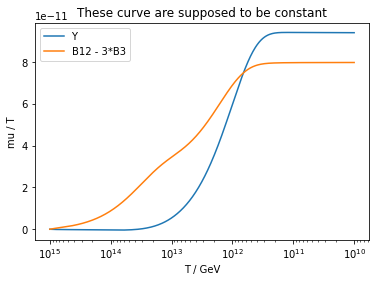

In [30]:
for i, n_A in enumerate(conserved):
    plt.semilogx(res_SS_const.T, n_A @ res_SS_const.red_chem_pots, label=conserved_names[i])
plt.gca().invert_xaxis()
plt.legend()
plt.xlabel("T / GeV")
plt.ylabel("mu / T")
plt.title("These curve are supposed to be constant")

/home/jana/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in double_scalars
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


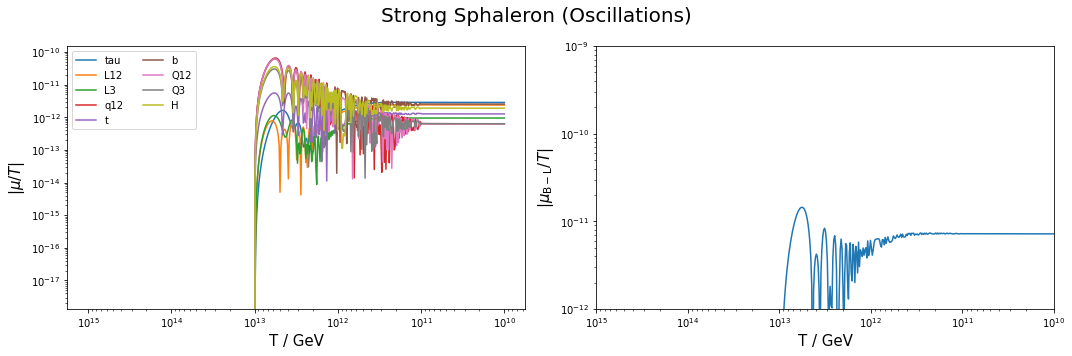

In [31]:
res = solve_and_plot(source_vector_strong_sphaleron, calc_axion_motion_osc, "Strong Sphaleron (Oscillations)", 
                    solver_kwargs=dict(solver="Radau", rtol=1e-8))
               #solver_kwargs=dict(solver="BDF", rtol=1e-10), yscale="linear", use_limits=False)

In [32]:
res.red_chem_pots.shape

(9, 500)

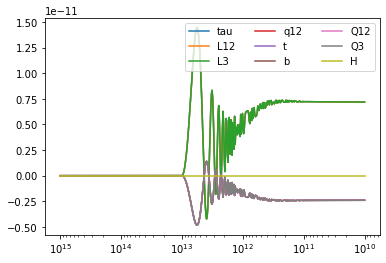

In [33]:
for i, y in enumerate(charge_vector_B_minus_L[:, None] * res.red_chem_B_minus_L):
    plt.semilogx(res.T, y, label=charge_names[i])
plt.legend(ncol=3)
plt.gca().invert_xaxis()

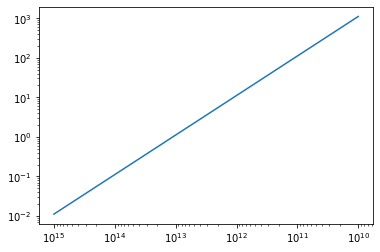

In [34]:
plt.loglog(np.exp(steps), rate(steps)[1, :])
plt.gca().invert_xaxis()

## Equilibrium Solution

In [35]:
# check if our charge vectors are linearly independent i.e. if \{n^\alpha\} is \{n^{\hat{\alpha}}\}
I = np.eye(N)
matrix = np.vstack([charge_vector, I[N_alpha:, :]])
assert not np.isclose(la.det(matrix), 0.0), "need to construct the alpha hat basis"
N_alpha_hat = N_alpha
charge_vector_hat = charge_vector

In [36]:
# construct dual basis
basis = np.vstack([charge_vector_hat, conserved])
ONB_T, A = la.qr(basis.T, pivoting=False)
dual = la.inv(A) @ ONB_T.T
dual_charges = dual[:N_alpha, :]

In [37]:
U = dual_charges @ charge_vector_hat.T

In [38]:
assert np.all(np.round(U, decimals=10) == np.eye(N_alpha)), \
    "dual basis works, if alpha /= alpha hat then this will have a shape error and should error earlier"

In [39]:
M = np.vstack([charge_vector_hat, g[None, :] * conserved])

In [40]:
def calc_equi(T, n_S):
    Gamma_vector = calc_rate_vector(T)
    Gamma_matrix = sum(Gamma_vector[alpha] * np.outer(charge_vector[alpha], charge_vector[alpha]) 
                       for alpha in range(N_alpha))
    Gamma_diag = np.diag(Gamma_vector)
    Gamma_hat_matrix = U @ Gamma_diag @ U.T
    S_matrix = U @ Gamma_diag # not the S matrix!
    upper = la.inv(Gamma_hat_matrix) @ S_matrix @ n_S * calc_axion_motion(np.log(T))
    vec = np.hstack([upper, np.zeros(N_A)])
    red_chem_pots_eq = la.inv(M).T @ vec
    return red_chem_pots_eq

def calc_equi_B_minus_L(T, n_S):
    return calc_B_minus_L(calc_equi(T, n_S))

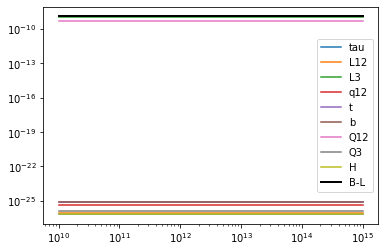

In [41]:
T_range = np.exp(steps)

n_S = source_vector_weak_sphaleron
calc_axion_motion = calc_axion_motion_const

equis = [calc_equi(T, n_S) for T in T_range]

for i in range(N):
    plt.loglog(T_range, np.abs([e[i] for e in equis]), label=charge_names[i])
plt.loglog(T_range, [np.abs(calc_equi_B_minus_L(T, n_S)) for T in T_range], color="black", lw=2, label="B-L")
plt.legend()

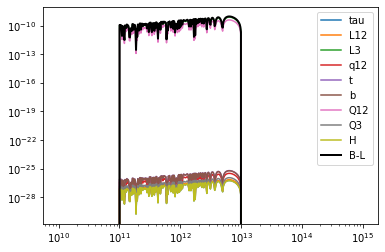

In [42]:
T_range = np.exp(steps)

n_S = source_vector_weak_sphaleron
calc_axion_motion = calc_axion_motion_osc

equis = [calc_equi(T, n_S) for T in T_range]

for i in range(N):
    plt.loglog(T_range, np.abs([e[i] for e in equis]), label=charge_names[i])
plt.loglog(T_range, [np.abs(calc_equi_B_minus_L(T, n_S)) for T in T_range], color="black", lw=2, label="B-L")
plt.legend()